In [2]:
#from audioop import mul
#from multiprocessing.context import assert_spawning
import os
#from statistics import mode
import timeit
#from bitarray import test

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
#from sympy import N


print("---Reading input file to pandas Dataframe---")
# dataset path
path = 'data'
file_name = 'churnsimulateddata.csv'
file = os.path.join(path, file_name)
print(file)
# read data
df = pd.read_csv(file)
print(f'Shape of original data: {df.shape}')

print("---Select features---")
feature_names = ['Age','Tenure','PSYTE_Segment','Total_score','Trnx_count','num_products', 'Churn_risk']
#feature_names = ['Age','PSYTE_Segment','Total_score','Churn_risk']
#feature_names = ['PSYTE_Segment','Total_score','Churn_risk']

selected_df = df[feature_names]

selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'  

selected_df['Churn_risk'] = selected_df.Churn_risk.astype("category").cat.codes

print(selected_df['Churn_risk'].unique())

selected_df = selected_df.dropna()
#selected_df = selected_df.drop(selected_df[(selected_df.Churn_risk != 0) or (selected_df.Churn_risk != 1) (selected_df.Churn_risk != 2)].index)
#print(selected_df['Churn_risk'].unique())


print('---Simulating clients based on geographical locations of the banks---') 
geo_split = 'T'
if geo_split:
    selected_df_v2 = selected_df.sample(frac=1)
    clients_data = []
    for i in range(0, 60, 10):
        clients_data.append(selected_df_v2[(selected_df_v2.PSYTE_Segment >= i) & (selected_df_v2.PSYTE_Segment < i+10)]) 
    
else:
    n_clients = 10
    clients_data = np.array_split(selected_df.sample(frac=1), n_clients)
    
print(f'Number of {np.size(clients_data)} clients. ')
X_train = []
X_test = []
y_train = []
y_test = []
for i, client_data in enumerate(clients_data):
    X = client_data.drop(columns=['Churn_risk','PSYTE_Segment'])
    print(X.columns)
    y = client_data['Churn_risk']
    
    _X_train, _X_test, _y_train, _y_test = train_test_split(
    X, y, test_size=0.2, random_state=42) 
    print(np.shape(_X_train))
    
    from imblearn.over_sampling import SMOTE, ADASYN
    #_X_train, _y_train = SMOTE().fit_resample(_X_train, _y_train)
    #_X_train, _y_train = ADASYN().fit_resample(_X_train, _y_train)

    
    print(np.shape(_X_train))

    X_train.append(_X_train)
    X_test.append(_X_test)
    y_train.append(_y_train)
    y_test.append(_y_test)


class LR_ScikitModel():
    def __init__(self):
        self.name = 'LR'

    def fit(self, X_train, X_test, y_train, y_test):

        clf = LogisticRegression(multi_class='auto', max_iter=1000, n_jobs=-1)
        starttime = timeit.default_timer()
        #Train the model using the training sets y_pred=clf.predict(X_test)
        clf.fit(X_train, y_train)
        model_params = clf.get_params() 
        training_time = timeit.default_timer() - starttime
        print("The training time is :", training_time)
        #starttime = timeit.default_timer()
        y_pred=clf.predict(X_test)
        #precison = metrics.precision_score(y_test, y_pred, average='weighted')
        #print('Precison: ', precison)
        #recall = metrics.recall_score(y_test, y_pred, average='weighted')
        #print('Recall: ', recall)
        #f1 = metrics.f1_score(self.y_test, self.y_pred, average='weighted')
        #print('F1: ', f1)
        accuracy = accuracy_score(y_test, y_pred)
        print('Accuracy: ', accuracy)
        print(classification_report(y_test, y_pred, zero_division=0))
        #print('Intercept')
        #print(clf.intercept_)
        #print('Coefficients')
        #print(clf.coef_)
        
        #testing_time = timeit.default_timer() - starttime
        #print("The testing time is :", testing_time)
        return clf.intercept_, clf.coef_, accuracy


print('---Training local models at local clients---')
#Training Local model
intercept_l = []
coef_l = []
accuracy_l = []
for i in range(np.size(clients_data)):
    print(f'client No {i}')
    model = LR_ScikitModel()
    intercept, coef, accuracy =  model.fit(X_train[i], X_test[i], y_train[i], y_test[i])
    intercept_l.append(intercept)
    coef_l.append(coef)
    accuracy_l.append(accuracy)
#print(intercept_l)
#print(coef_l)
#print(accuracy_l)


print('---Aggregating at the aggregation server---')
#averaged the local weights
#print(np.sum(intercept_l,axis=0))
#print(np.sum(coef_l,axis=0))   # axis1=3 becasue there is 3 classes


print('---Constructing model---')
#averaged the local weights
global_intercept = np.sum(intercept_l,axis=0)
global_coef = np.sum(coef_l,axis=0) 
print(global_intercept)
print(global_coef)   # axis1=3 becasue there is 3 classes


print('---Testing on local clients---')
#
#print(np.sum(intercept_l,axis=0))
#print(np.sum(coef_l,axis=0))   # axis1=3 becasue there is 3 classes



def multiclass_LogisticFunction(X, W, b):
    '''
    Logistics Regression function
    Input: 
        X: input data in form of a matrix with size (n_samples, n_features)
        W: Weight or logistics coefficient matrix with size (n_classes, n_features)
        b: bias or intercept vector with size (n_classes)  
        ref: https://github.com/bamtak/machine-learning-implemetation-python/blob/master/Multi%20Class%20Logistic%20Regression.ipynb
    '''

    def softmax(z):
        prob = np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)
        return prob
            
    def predict_(X, W, b):

        assert np.shape(X)[1] == np.shape(W)[1]   
        assert np.shape(W)[0] == np.shape(b)[0]   

        pre_vals = np.dot(X, W.T) + b
        return softmax(pre_vals)
    
    probability = predict_(X, W, b)
    max_prob = np.amax(probability, axis=1, keepdims=True)
    #print(np.shape(max_prob))
    label = np.argmax(probability, axis=1)

    return label



print('---Testing global model on local testing data---')
for i in range(np.size(clients_data)):
    print(f'client No {i}')
    model = LR_ScikitModel()

    label =  multiclass_LogisticFunction(X_test[i], np.array(global_coef), np.array(global_intercept))
    print(classification_report(y_test[i], label, zero_division=0))

    


---Reading input file to pandas Dataframe---
data/churnsimulateddata.csv
Shape of original data: (706693, 19)
---Select features---
[1 0]
---Simulating clients based on geographical locations of the banks---
Number of 6 clients. 
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products'], dtype='object')
(127535, 5)


/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_41404/1301323787.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'
/opt/anaconda3/lib/python3.9/site-packages/pandas/core/generic.py:8870: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)
/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_41404/1301323787.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation:

(127535, 5)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products'], dtype='object')
(160520, 5)
(160520, 5)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products'], dtype='object')
(105359, 5)
(105359, 5)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products'], dtype='object')
(72392, 5)
(72392, 5)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products'], dtype='object')
(38397, 5)
(38397, 5)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products'], dtype='object')
(61148, 5)
(61148, 5)
---Training local models at local clients---
client No 0
The training time is : 1.2816628750000518
Accuracy:  0.8334274244134989
              precision    recall  f1-score   support

           0       0.79      0.79      0.79     12555
           1       0.86      0.86      0.86     19329

    accuracy                           0.83     31884
   macro avg       0.83      0.83      0.83     31884
weighted avg       0.83      0.83      0.83

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [14]:
print(np.shape(y_test))

(6,)


/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [15]:
np.array(global_coef), np.array(global_intercept)

(array([[-1.02300370e-01,  2.79518880e-01,  9.59302175e-01,
          1.81650129e-03,  2.87066376e+00]]),
 array([-16.99110949]))

In [16]:





def multiclass_LogisticFunction(X, W, b):
    '''
    Logistics Regression function
    Input: 
        X: input data in form of a matrix with size (n_samples, n_features)
        W: Weight or logistics coefficient matrix with size (n_classes, n_features)
        b: bias or intercept vector with size (n_classes)  
        ref: https://github.com/bamtak/machine-learning-implemetation-python/blob/master/Multi%20Class%20Logistic%20Regression.ipynb
    '''

    def softmax(z):
        prob = np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)
        return prob
            
    def predict_(X, W, b):

        assert np.shape(X)[1] == np.shape(W)[1]   
        assert np.shape(W)[0] == np.shape(b)[0]   

        pre_vals = np.dot(X, W.T) + b
        return softmax(pre_vals)
    
    probability = predict_(X, W, b)
    max_prob = np.amax(probability, axis=1, keepdims=True)
    #print(np.shape(max_prob))
    label = np.argmax(probability, axis=1)

    return label



print('---Testing global model on local testing data---')
gl_m_accuracy_l = []
for i in range(np.size(clients_data)):
    print(f'client No {i}')
    model = LR_ScikitModel()

    label =  multiclass_LogisticFunction(X_test[i], np.array(global_coef), np.array(global_intercept))
    gl_m_accuracy = round(accuracy_score(y_test[i], label)*100,2)
    print('Global model Accuracy: ', gl_m_accuracy)
    gl_m_accuracy_l.append(gl_m_accuracy)
    print(classification_report(y_test[i], label, zero_division=0))
    
    
print(accuracy_l, np.mean(accuracy_l))
print(gl_m_accuracy_l, np.mean(gl_m_accuracy_l))





---Testing global model on local testing data---
client No 0
Global model Accuracy:  38.94
              precision    recall  f1-score   support

           0       0.39      1.00      0.56     12416
           1       0.00      0.00      0.00     19468

    accuracy                           0.39     31884
   macro avg       0.19      0.50      0.28     31884
weighted avg       0.15      0.39      0.22     31884

client No 1
Global model Accuracy:  41.51
              precision    recall  f1-score   support

           0       0.42      1.00      0.59     16660
           1       0.00      0.00      0.00     23471

    accuracy                           0.42     40131
   macro avg       0.21      0.50      0.29     40131
weighted avg       0.17      0.42      0.24     40131

client No 2
Global model Accuracy:  39.57
              precision    recall  f1-score   support

           0       0.40      1.00      0.57     10423
           1       0.00      0.00      0.00     15917

    acc

In [ ]:
df
df.loc[df.Churn_risk[df.Churn_risk == 'Medium'],df.Churn_risk] =  1

In [ ]:
print(df)

In [2]:
import numpy as np
help(
    np.multiply)

Help on ufunc:

multiply = <ufunc 'multiply'>
    multiply(x1, x2, /, out=None, *, where=True, casting='same_kind', order='K', dtype=None, subok=True[, signature, extobj])
    
    Multiply arguments element-wise.
    
    Parameters
    ----------
    x1, x2 : array_like
        Input arrays to be multiplied.
        If ``x1.shape != x2.shape``, they must be broadcastable to a common
        shape (which becomes the shape of the output).
    out : ndarray, None, or tuple of ndarray and None, optional
        A location into which the result is stored. If provided, it must have
        a shape that the inputs broadcast to. If not provided or None,
        a freshly-allocated array is returned. A tuple (possible only as a
        keyword argument) must have length equal to the number of outputs.
    where : array_like, optional
        This condition is broadcast over the input. At locations where the
        condition is True, the `out` array will be set to the ufunc result.
        El

In [3]:
#from audioop import mul
#from multiprocessing.context import assert_spawning
import os
#from statistics import mode
import timeit
#from bitarray import test

import numpy as np
import pandas as pd


from sklearn.utils import resample
from sklearn.model_selection import train_test_split
#from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
#from sympy import N


print("---Reading input file to pandas Dataframe---")
# dataset path
path = 'data'
file_name = 'churnsimulateddata.csv'
file = os.path.join(path, file_name)
print(file)
# read data
df = pd.read_csv(file)
print(f'Shape of original data: {df.shape}')

print("---Select features---")
feature_names = ['Age','Tenure','PSYTE_Segment','Total_score','Trnx_count','num_products', 'Churn_risk']
#feature_names = ['Age','PSYTE_Segment','Total_score','Churn_risk']
#feature_names = ['PSYTE_Segment','Total_score','Churn_risk']

selected_df = df[feature_names].dropna()


#selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = 'High'  

selected_df['Churn_risk'] = selected_df.Churn_risk.astype("category").cat.codes
selected_df['A'] = selected_df.Age * selected_df.Total_score
#selected_df['B'] = selected_df.Churn_risk * selected_df.Total_score


#print(selected_df['Churn_risk'][selected_df['Churn_risk_code'] == 0]) #HIGH
#print(selected_df['Churn_risk'][selected_df['Churn_risk_code'] == 1]) #LOW
#print(selected_df['Churn_risk'][selected_df['Churn_risk_code'] == 2]) #MED

#selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Medium'] = '1'
#selected_df['Churn_risk'][selected_df['Churn_risk'] == 'Low'] = '0'
#selected_df['Churn_risk'][selected_df['Churn_risk'] == 'High'] = '2'


print(selected_df['Churn_risk'].unique())

selected_df = selected_df.dropna()
#selected_df = selected_df.drop(selected_df[(selected_df.Churn_risk != 0) or (selected_df.Churn_risk != 1) (selected_df.Churn_risk != 2)].index)
#print(selected_df['Churn_risk'].unique())

classes = np.unique(selected_df['Churn_risk'])
class_labels = {c:i for i,c in enumerate(classes)}
def one_hot(y):
    return np.eye(len(classes))[np.vectorize(lambda c: class_labels[c])(y).reshape(-1)]

print('---Simulating clients based on geographical locations of the banks---') 
geo_split = 'T'
if geo_split:
    selected_df_v2 = selected_df.sample(frac=1)
    clients_data = []
    for i in range(0, 60, 10):
        y = selected_df_v2[(selected_df_v2.PSYTE_Segment >= i) & (selected_df_v2.PSYTE_Segment < i+10)]
        clients_data.append(y) 
    
else:
    n_clients = 10
    clients_data = np.array_split(selected_df.sample(frac=1), n_clients)
    
print(f'Number of {np.size(clients_data)} clients. ')
X_train = []
X_test = []
y_train = []
y_test = []
for i, client_data in enumerate(clients_data):
    X = client_data.drop(columns=['Churn_risk','PSYTE_Segment'])
    print(X.columns)
    y = client_data['Churn_risk']
    print(y.unique())
    _X_train, _X_test, _y_train, _y_test = train_test_split(
    X, y, test_size=0.2, random_state=42) 
    
    print(np.shape(_X_train))

    
    '''
    # downsample majority
    # concatenate our training data back together
    X = pd.concat([_X_train, _y_train], axis=1)
    low = X[X.Churn_risk==1]
    high = X[X.Churn_risk==0]
    medium = X[X.Churn_risk==2]
    
    X.Churn_risk.value_counts()

    low_downsampled = resample(low,
                                replace = False, # sample without replacement
                                n_samples = len(medium), # match minority n
                                random_state = 27) # reproducible results

    # combine minority and downsampled majority
    downsampled = pd.concat([low_downsampled, high, medium])

    # checking counts
    downsampled.Churn_risk.value_counts()

    _X_train = downsampled.drop('Churn_risk', axis=1)
    _y_train = downsampled.Churn_risk
    '''

    #oversamppling
    from imblearn.over_sampling import SMOTE, ADASYN
    #_X_train, _y_train = SMOTE().fit_resample(_X_train, _y_train)
    #_X_train, _y_train = ADASYN().fit_resample(_X_train, _y_train)

    
    print(np.shape(_X_train))

    X_train.append(_X_train)
    X_test.append(_X_test)
    y_train.append(_y_train)
    y_test.append(_y_test)


class LR_ScikitModel():
    def __init__(self):
        self.name = 'LR'

    def fit(self, X_train, X_test, y_train, y_test):

        clf = LogisticRegression(multi_class='multinomial', max_iter=10, n_jobs=-1)
        #clf = LogisticRegression(multi_class='auto', max_iter=500, n_jobs=-1)
        
        starttime = timeit.default_timer()
        #Train the model using the training sets y_pred=clf.predict(X_test)
        print(X_train)
        print(y_train)
        
        clf.fit(X_train, y_train)
        model_params = clf.get_params() 
        training_time = timeit.default_timer() - starttime
        print("The training time is :", training_time)
        #starttime = timeit.default_timer()
        y_pred=clf.predict(X_test)
        #precison = metrics.precision_score(y_test, y_pred, average='weighted')
        #print('Precison: ', precison)
        #recall = metrics.recall_score(y_test, y_pred, average='weighted')
        #print('Recall: ', recall)
        #f1 = metrics.f1_score(self.y_test, self.y_pred, average='weighted')
        #print('F1: ', f1)
        accuracy = round(accuracy_score(y_test, y_pred)*100,2)
        print('Accuracy: ', accuracy)
        print(classification_report(y_test, y_pred, zero_division=0))
        #print('Intercept')
        #print(clf.intercept_)
        #print('Coefficients')
        #print(clf.coef_)
        
        #testing_time = timeit.default_timer() - starttime
        #print("The testing time is :", testing_time)
        return clf.intercept_, clf.coef_, accuracy


print('---Training local models at local clients---')
#Training Local model
intercept_l = []
coef_l = []
row_l = []
accuracy_l = []
for i in range(np.size(clients_data)):
    print(f'client No {i}')
    model = LR_ScikitModel()
    print(y_train[i].unique(), y_test[i].unique())
    intercept, coef, accuracy =  model.fit(X_train[i], X_test[i], y_train[i], y_test[i])
    intercept_l.append(intercept)
    coef_l.append(coef)
    accuracy_l.append(accuracy)
    row_l.append(np.size(accuracy))
print(intercept_l)
print(coef_l)
print(accuracy_l)


print('---Aggregating at the aggregation server---')
#averaged the local weights
#print(np.sum(intercept_l,axis=0))
#print(np.sum(coef_l,axis=0))   # axis1=3 becasue there is 3 classes


print('---Constructing model---')
#averaged the local weights
global_intercept = np.sum(intercept_l,axis=0)
global_coef = np.sum(coef_l,axis=0) 
#print(np.shape(global_intercept))
#print(np.shape(global_coef))   # axis1=3 becasue there is 3 classes
#global_intercept = np.sum(intercept_l*row_l)/np.sum(row_l)
#global_coef = np.sum(np.multiply(coef_l, row_l))/np.sum(row_l)
#print(np.shape(global_intercept))
#print(np.shape(global_coef))


print('---Testing on local clients---')
#
#print(np.sum(intercept_l,axis=0))
#print(np.sum(coef_l,axis=0))   # axis1=3 becasue there is 3 classes



def multiclass_LogisticFunction(X, W, b):
    '''
    Logistics Regression function
    Input: 
        X: input data in form of a matrix with size (n_samples, n_features)
        W: Weight or logistics coefficient matrix with size (n_classes, n_features)
        b: bias or intercept vector with size (n_classes)  
        ref: https://github.com/bamtak/machine-learning-implemetation-python/blob/master/Multi%20Class%20Logistic%20Regression.ipynb
    '''

    def softmax(z):
        prob = np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1,1)
        return prob
            
    def predict_(X, W, b):

        assert np.shape(X)[1] == np.shape(W)[1]   
        assert np.shape(W)[0] == np.shape(b)[0]   

        pre_vals = np.dot(X, W.T) + b
        return softmax(pre_vals)
    
    probability = predict_(X, W, b)
    max_prob = np.amax(probability, axis=1, keepdims=True)
    #print(np.shape(max_prob))
    label = np.argmax(probability, axis=1)

    return label



print('---Testing global model on local testing data---')
gl_m_accuracy_l = []
for i in range(np.size(clients_data)):
    print(f'client No {i}')
    model = LR_ScikitModel()

    label =  multiclass_LogisticFunction(X_test[i], np.array(global_coef), np.array(global_intercept))
    gl_m_accuracy = round(accuracy_score(y_test[i], label)*100,2)
    print('Global model Accuracy: ', gl_m_accuracy)
    gl_m_accuracy_l.append(gl_m_accuracy)
    print(classification_report(y_test[i], label, zero_division=0))
    
    
print(accuracy_l, np.mean(accuracy_l))
print(gl_m_accuracy_l, np.mean(gl_m_accuracy_l))




---Reading input file to pandas Dataframe---
data/churnsimulateddata.csv
Shape of original data: (706693, 19)
---Select features---
[1 2 0]
---Simulating clients based on geographical locations of the banks---
Number of 6 clients. 
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products', 'A'], dtype='object')
[1 0 2]
(127535, 6)
(127535, 6)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products', 'A'], dtype='object')
[0 1 2]
(160520, 6)
(160520, 6)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products', 'A'], dtype='object')
[1 2 0]
(105359, 6)
(105359, 6)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products', 'A'], dtype='object')
[0 1 2]
(72392, 6)
(72392, 6)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products', 'A'], dtype='object')
[1 2 0]
(38397, 6)
(38397, 6)
Index(['Age', 'Tenure', 'Total_score', 'Trnx_count', 'num_products', 'A'], dtype='object')
[1 0 2]
(61148, 6)
(61148, 6)
---Training local models at local cl

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training time is : 1.4623351249992993
Accuracy:  70.64
              precision    recall  f1-score   support

           0       0.84      0.10      0.18      4676
           1       0.81      0.93      0.86     19362
           2       0.45      0.53      0.49      7846

    accuracy                           0.71     31884
   macro avg       0.70      0.52      0.51     31884
weighted avg       0.72      0.71      0.67     31884

client No 1
[1 2 0] [2 1 0]
        Age  Tenure  Total_score  Trnx_count  num_products            A
534294   55      24    33.666667           4             2  1851.666667
514073   39       6    22.166667         117             1   864.500000
568516   58       2     4.333333         183             1   251.333333
340513   71       0     7.666667           3             1   544.333333
323787   51       1     1.333333           7             2    68.000000
...     ...     ...          ...         ...           ...          ...
579729   46       3     6.00

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training time is : 0.8829113749998214
Accuracy:  66.63
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      5667
           1       0.74      0.94      0.83     23537
           2       0.45      0.41      0.43     10927

    accuracy                           0.67     40131
   macro avg       0.40      0.45      0.42     40131
weighted avg       0.56      0.67      0.60     40131

client No 2
[1 2 0] [2 1 0]
        Age  Tenure  Total_score  Trnx_count  num_products            A
74245    46      24    40.666667          55             2  1870.666667
542116   56       1    36.666667           4             2  2053.333333
619110   59      33    13.833333         626             2   816.166667
213302   22       1     0.000000         195             2     0.000000
201687   49       6    30.833333          28             2  1510.833333
...     ...     ...          ...         ...           ...          ...
31885    20       3    21.83

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training time is : 0.7275706669997817
Accuracy:  67.12
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      3534
           1       0.74      0.95      0.83     15827
           2       0.44      0.37      0.40      6979

    accuracy                           0.67     26340
   macro avg       0.39      0.44      0.41     26340
weighted avg       0.56      0.67      0.61     26340

client No 3
[1 0 2] [0 1 2]
        Age  Tenure  Total_score  Trnx_count  num_products            A
105331   54      39    55.166667          50             4  2979.000000
283655   50       0    12.666667          17             2   633.333333
219105   68       9     8.166667          27             1   555.333333
276929   50      15    13.166667           4             1   658.333333
203305   65      20    34.000000          11             4  2210.000000
...     ...     ...          ...         ...           ...          ...
566444   27       3     9.00

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training time is : 0.619735166999817
Accuracy:  66.66
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      2436
           1       0.74      0.94      0.83     10768
           2       0.44      0.39      0.41      4895

    accuracy                           0.67     18099
   macro avg       0.39      0.44      0.41     18099
weighted avg       0.56      0.67      0.60     18099

client No 4
[2 0 1] [2 1 0]
        Age  Tenure  Total_score  Trnx_count  num_products            A
222826   40       6     1.833333          57             2    73.333333
296873   65      21     1.500000          13             2    97.500000
180392   24      11    32.500000          84             2   780.000000
30011    50      31    25.166667         121             5  1258.333333
704439   39       7     7.166667          42             1   279.500000
...     ...     ...          ...         ...           ...          ...
379378   66       2    14.833

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training time is : 0.5119907500002228
Accuracy:  63.12
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1537
           1       0.70      0.94      0.80      5299
           2       0.43      0.39      0.41      2764

    accuracy                           0.63      9600
   macro avg       0.38      0.44      0.41      9600
weighted avg       0.51      0.63      0.56      9600

client No 5
[2 1 0] [1 0 2]
        Age  Tenure  Total_score  Trnx_count  num_products            A
577658   87      45    12.166667          12             2  1058.500000
222903   27      23     7.666667         137             3   207.000000
587310   38      13     1.500000         283             1    57.000000
39158    35       2    22.833333         100             2   799.166667
607866   50       0     0.500000         163             1    25.000000
...     ...     ...          ...         ...           ...          ...
219650   40       4     8.66

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


The training time is : 0.724646916999518
Accuracy:  64.7
              precision    recall  f1-score   support

           0       0.79      0.26      0.39      2729
           1       0.69      0.93      0.79      8061
           2       0.48      0.38      0.42      4498

    accuracy                           0.65     15288
   macro avg       0.65      0.52      0.54     15288
weighted avg       0.65      0.65      0.61     15288

[array([ 0.00022204, -0.00036875,  0.00014671]), array([ 6.34492089e-05, -1.27139667e-04,  6.36904577e-05]), array([ 4.94228878e-05, -1.07728907e-04,  5.83060191e-05]), array([ 7.96757407e-05, -1.59013683e-04,  7.93379421e-05]), array([ 7.03996921e-05, -1.39526366e-04,  6.91266736e-05]), array([ 9.67864203e-05, -1.69083973e-04,  7.22975531e-05])]
[array([[ 1.23649509e-02,  7.77695958e-04, -8.57747894e-04,
        -4.74196027e-03,  8.99774481e-05, -1.86673072e-03],
       [-2.28737437e-02, -1.43591828e-03,  2.50138534e-03,
         2.81603643e-03, -1.045813

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


In [8]:
global_intercept = np.sum(intercept_l,axis=0)
global_coef = np.sum(coef_l,axis=0) 
print(np.shape(intercept_l))
print(np.shape(coef_l))   # axis1=3 becasue there is 3 classes
print(np.shape(row_l))
#global_intercept = np.sum(intercept_l*row_l)/np.sum(row_l)
#global_coef = np.sum(np.multiply(coef_l, row_l))/np.sum(row_l)
#print(np.shape(global_intercept))
#print(np.shape(global_coef))




(6, 3)
(6, 3, 6)
(6,)


In [13]:
from sklearn.metrics import accuracy_score, classification_report, f1_score
gl_m_accuracy = f1_score(y_test[i], label,average=None)

In [14]:
gl_m_accuracy

array([0.        , 0.79530237, 0.42728984])

In [21]:

a = [[0.71101752, 0.7836647 , 0.50746934], [0.71278725, 0.79218125, 0.517991  ], [0.69646681, 0.78045157, 0.50823673], [0.69844284, 0.77568922, 0.49197145], [0.68932331, 0.77653997, 0.4966818 ], [0.69084746, 0.77533719, 0.49375755]] 
b = [[0.7104107 , 0.78084087, 0.49949193], [0.7124484 , 0.7912401 , 0.51175971], [0.6972058 , 0.77861246, 0.50651141], [0.6998088 , 0.77641686, 0.49832999], [0.68797106, 0.77594184, 0.49982741], [0.69178547, 0.7714565 , 0.49356308]]

In [22]:
print(a)

[[0.71101752, 0.7836647, 0.50746934], [0.71278725, 0.79218125, 0.517991], [0.69646681, 0.78045157, 0.50823673], [0.69844284, 0.77568922, 0.49197145], [0.68932331, 0.77653997, 0.4966818], [0.69084746, 0.77533719, 0.49375755]]


In [23]:
print(b)

[[0.7104107, 0.78084087, 0.49949193], [0.7124484, 0.7912401, 0.51175971], [0.6972058, 0.77861246, 0.50651141], [0.6998088, 0.77641686, 0.49832999], [0.68797106, 0.77594184, 0.49982741], [0.69178547, 0.7714565, 0.49356308]]


[Text(0, 0, 'High'), Text(1, 0, 'Low'), Text(2, 0, 'Medium')]

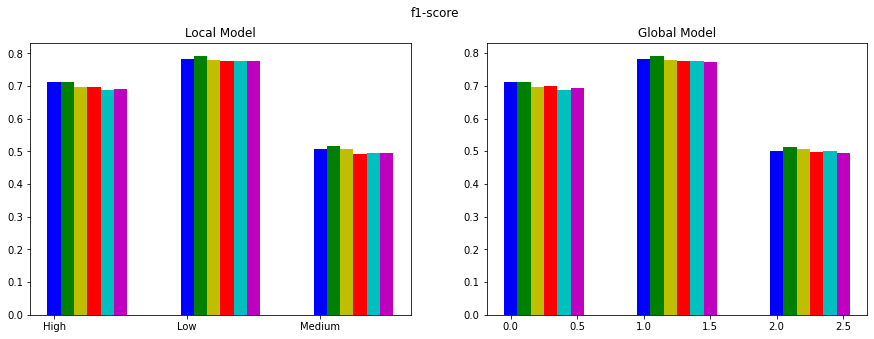

In [63]:
import numpy as np
import matplotlib.pyplot as plt
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('f1-score')
data = [[0.71101752, 0.7836647 , 0.50746934], [0.71278725, 0.79218125, 0.517991  ], [0.69646681, 0.78045157, 0.50823673], [0.69844284, 0.77568922, 0.49197145], [0.68932331, 0.77653997, 0.4966818 ], [0.69084746, 0.77533719, 0.49375755]] 
data_b = [[0.7104107 , 0.78084087, 0.49949193], [0.7124484 , 0.7912401 , 0.51175971], [0.6972058 , 0.77861246, 0.50651141], [0.6998088 , 0.77641686, 0.49832999], [0.68797106, 0.77594184, 0.49982741], [0.69178547, 0.7714565 , 0.49356308]]

X = np.arange(3)
#fig = plt.figure()
#ax1 = fig.add_axes([0,0,1,1])
color_l = ['b','g', 'y','r','c', 'm', 'k', 'black','purple', 'pink', 'olive', 'gray', 'orange', 'lime']
for i in range(np.shape(data)[0]):
    ax1.bar(X + 0.1*i, data[i], color = color_l[i], width = 0.1)
ax1.set_title('Local Model')
ax1.set_xlabel('')
ax1.set_xticks([0,1,2])
#ax1.set_xticks(['High','Low','Medium'])
ax1.set_xticklabels(['High','Low','Medium'])




for i in range(np.shape(data)[0]):
    ax2.bar(X + 0.1*i, data_b[i], color = color_l[i], width = 0.1)
ax2.set_title('Global Model')
ax1.set_xticklabels(['High','Low','Medium'])






/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_42308/1907439723.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['High','Low','Medium'])


(0.4, 0.8)

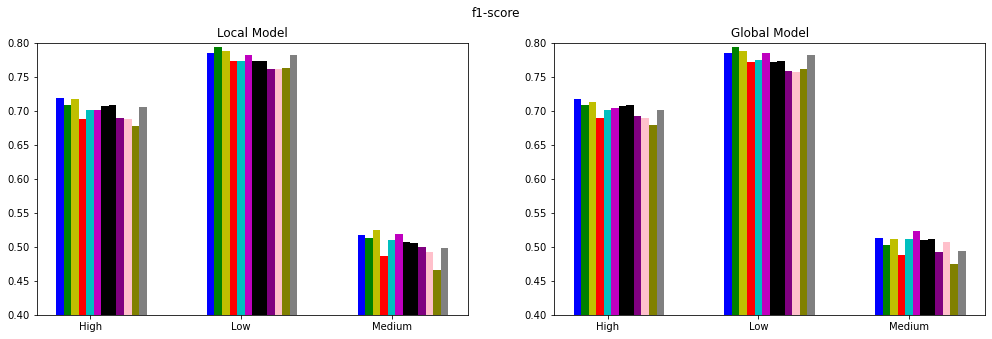

In [89]:
data = [[0.71858002, 0.78539607, 0.51764706], [0.70903522, 0.79434704, 0.51279562], [0.71717422, 0.78819733, 0.52413793], [0.68879128, 0.77404108, 0.48724781], [0.70168122, 0.77377145, 0.50980971], [0.70197244, 0.78187221, 0.51945289], [0.70777378, 0.77360033, 0.50754516], [0.70929998, 0.77409507, 0.50526316], [0.68939864, 0.76226158, 0.49964614], [0.68831169, 0.76148366, 0.49173445], [0.67838019, 0.76283252, 0.46663987], [0.70535349, 0.78248848, 0.49773756]]
data_b = [[0.71805662, 0.78485075, 0.51299359], [0.70827981, 0.79468711, 0.50300587], [0.71390091, 0.78776713, 0.51228752], [0.6896106 , 0.77158672, 0.48856981], [0.70182343, 0.77485254, 0.51095323], [0.70440252, 0.78589055, 0.52266093], [0.70727065, 0.77257933, 0.51017812], [0.70912779, 0.77412281, 0.51109057], [0.69223631, 0.75843271, 0.4929078 ], [0.6903255 , 0.75666164, 0.50684237], [0.67907445, 0.76197719, 0.47414133], [0.70121457, 0.78236398, 0.49401198]]


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle('f1-score')
X = np.arange(3)
#fig = plt.figure()
#ax1 = fig.add_axes([0,0,1,1])
color_l = ['b','g', 'y','r','c', 'm', 'k', 'black','purple', 'pink', 'olive', 'gray', 'orange', 'lime']
for i in range(np.shape(data)[0]):
    ax1.bar(X + 0.05*i, data[i], color = color_l[i], width = 0.05)
ax1.set_title('Local Model')
ax1.set_xlabel('')
ax1.set_xticks([0.2,1.2,2.2])
#ax1.set_xticks(['High','Low','Medium'])
ax1.set_xticklabels(['High','Low','Medium'])
#ax1.axhline(y=0.5, color='r', linestyle='-')
ax1.set_ylim([0.4, 0.8])



for i in range(np.shape(data)[0]):
    ax2.bar(X + 0.05*i, data_b[i], color = color_l[i], width = 0.05)
ax2.set_title('Global Model')
ax2.set_xticklabels(['High','Low','Medium'])
#ax2.axhline(y=0.5, color='r', linestyle='-')
ax2.set_xticks([0.2,1.2,2.2])
ax2.set_ylim([0.4, 0.8])







In [85]:
data = [[0.71858002, 0.78539607, 0.51764706], [0.70903522, 0.79434704, 0.51279562], [0.71717422, 0.78819733, 0.52413793], [0.68879128, 0.77404108, 0.48724781], [0.70168122, 0.77377145, 0.50980971], [0.70197244, 0.78187221, 0.51945289], [0.70777378, 0.77360033, 0.50754516], [0.70929998, 0.77409507, 0.50526316], [0.68939864, 0.76226158, 0.49964614], [0.68831169, 0.76148366, 0.49173445], [0.67838019, 0.76283252, 0.46663987], [0.70535349, 0.78248848, 0.49773756]]
data_b = [[0.71805662, 0.78485075, 0.51299359], [0.70827981, 0.79468711, 0.50300587], [0.71390091, 0.78776713, 0.51228752], [0.6896106 , 0.77158672, 0.48856981], [0.70182343, 0.77485254, 0.51095323], [0.70440252, 0.78589055, 0.52266093], [0.70727065, 0.77257933, 0.51017812], [0.70912779, 0.77412281, 0.51109057], [0.69223631, 0.75843271, 0.4929078 ], [0.6903255 , 0.75666164, 0.50684237], [0.67907445, 0.76197719, 0.47414133], [0.70121457, 0.78236398, 0.49401198]]



k = 0
for i in range(np.shape(data)[0]):
    for j in range(np.shape(data_b)[1]):
        diff =(data[i][j]-data_b[i][j])*100
        if diff>0:
            k = k+1
print(k)
        
        
19/36    

19


In [54]:
import matplotlib
print(matplotlib.colors)

<module 'matplotlib.colors' from '/opt/anaconda3/lib/python3.9/site-packages/matplotlib/colors.py'>


In [95]:
a = [0.6765301225454903, 0.6702671565450588, 0.6764931777943638, 0.6685905207298473, 0.6711576562164527, 0.6592708376515557, 0.6577360501934458, 0.656482168632823, 0.6707884595018007, 0.6706052415390984, 0.6583376210407832, 0.6519607133705146, 0.653086858937941, 0.6570538738263334, 0.6458673528116866, 0.646617347734729, 0.6475928993546793, 0.6502021042795388, 0.6564011177506406, 0.647701248870923]
b = [0.6761972164500972, 0.6665874275642723, 0.6722896348759132, 0.6637979781785084, 0.6649738334267362, 0.6553924910520864, 0.6558996429032516, 0.6552402164647865, 0.6702340478707268, 0.6706574558408115, 0.6605954525481206, 0.6520099109860761, 0.6552323624696191, 0.6553482336835563, 0.6509798146624776, 0.6550804474256651, 0.6516610570124689, 0.6539655253797728, 0.6523976853988731, 0.6444862310524677]
for i in range(np.size(a)):
    print(i)
    print((b[i]-a[i])*100)

0
-0.03329060953930485
1
-0.3679728980786501
2
-0.4203542918450598
3
-0.4792542551338874
4
-0.618382278971652
5
-0.38783465994692845
6
-0.18364072901941864
7
-0.12419521680365753
8
-0.05544116310738367
9
0.0052214301713093825
10
0.22578315073373822
11
0.004919761556143598
12
0.21455035316780835
13
-0.17056401427770762
14
0.511246185079095
15
0.846309969093606
16
0.4068157657789562
17
0.3763421100233977
18
-0.40034323517674775
19
-0.32150178184552347


/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_42308/1437713800.py:30: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['High','Low','Medium'])
No handles with labels found to put in legend.


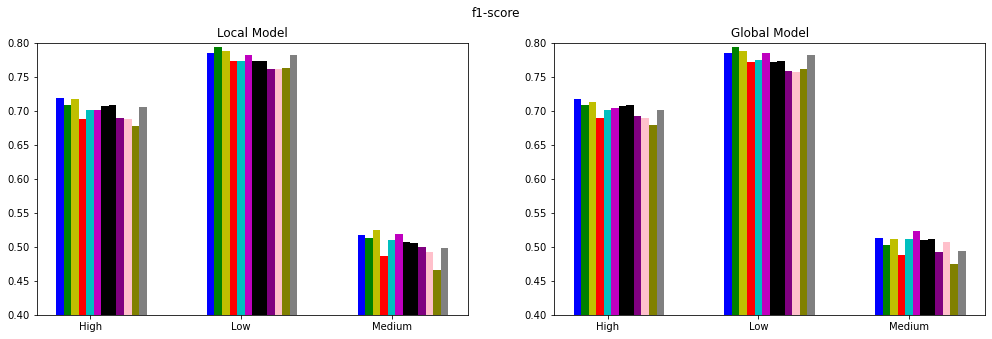

In [191]:
data = [[0.71858002, 0.78539607, 0.51764706], [0.70903522, 0.79434704, 0.51279562], [0.71717422, 0.78819733, 0.52413793], [0.68879128, 0.77404108, 0.48724781], [0.70168122, 0.77377145, 0.50980971], [0.70197244, 0.78187221, 0.51945289], [0.70777378, 0.77360033, 0.50754516], [0.70929998, 0.77409507, 0.50526316], [0.68939864, 0.76226158, 0.49964614], [0.68831169, 0.76148366, 0.49173445], [0.67838019, 0.76283252, 0.46663987], [0.70535349, 0.78248848, 0.49773756]]
data_b = [[0.71805662, 0.78485075, 0.51299359], [0.70827981, 0.79468711, 0.50300587], [0.71390091, 0.78776713, 0.51228752], [0.6896106 , 0.77158672, 0.48856981], [0.70182343, 0.77485254, 0.51095323], [0.70440252, 0.78589055, 0.52266093], [0.70727065, 0.77257933, 0.51017812], [0.70912779, 0.77412281, 0.51109057], [0.69223631, 0.75843271, 0.4929078 ], [0.6903255 , 0.75666164, 0.50684237], [0.67907445, 0.76197719, 0.47414133], [0.70121457, 0.78236398, 0.49401198]]

class_0 = [0.71858002, ]
class_1 = []
class_2 = []


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(17,5))
fig.suptitle('f1-score')
X = np.arange(3)
#fig = plt.figure()
#ax1 = fig.add_axes([0,0,1,1])
color_l = ['b','g', 'y','r','c', 'm', 'k', 'black','purple', 'pink', 'olive', 'gray', 'orange', 'lime']
for i in range(np.shape(data)[0]):
    ax1.bar(X + 0.05*i, data[i], color = color_l[i], width = 0.05)
ax1.set_title('Local Model')
ax1.set_xlabel('')
ax1.set_xticks([0.2,1.2,2.2])
#ax1.set_xticks(['High','Low','Medium'])
ax1.set_xticklabels(['High','Low','Medium'])
#ax1.axhline(y=0.5, color='r', linestyle='-')
ax1.set_ylim([0.4, 0.8])



for i in range(np.shape(data)[0]):
    ax2.bar(X + 0.05*i, data_b[i], color = color_l[i], width = 0.05)
ax2.set_title('Global Model')
ax2.set_xticklabels(['High','Low','Medium'])
#ax2.axhline(y=0.5, color='r', linestyle='-')
ax2.set_xticks([0.2,1.2,2.2])
ax2.set_ylim([0.4, 0.8])
ax.legend(loc='upper center', shadow=True, fontsize='x-large')






(3, 6)


/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_42308/1501618879.py:50: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(['Client 0','Client 1', 'Client 2', 'Client 3', 'Client 4', 'Client 5'])
/var/folders/7s/lxjghsr57nscy448l9t3l2800000gq/T/ipykernel_42308/1501618879.py:58: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(['Client 0','Client 1', 'Client 2', 'Client 3', 'Client 4', 'Client 5'])


(0.4, 0.8)

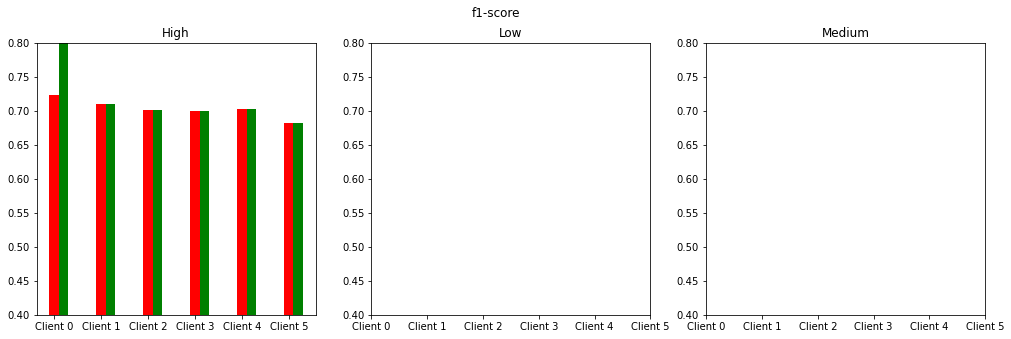

In [187]:
local = np.array([[0.72416771, 0.78731464, 0.52320393],
 [0.71057333, 0.7848602,  0.51432353],
 [0.70155356, 0.78050222, 0.52336165],
 [0.70031546, 0.77649909, 0.49657827],
 [0.70317175, 0.76688742, 0.48577525],
 [0.68265554, 0.76648352, 0.49356396]])

glob = np.array([[0.92416771, 0.78731464, 0.52320393],
 [0.71057333, 0.7848602,  0.51432353],
 [0.70155356, 0.78050222, 0.52336165],
 [0.70031546, 0.77649909, 0.49657827],
 [0.70317175, 0.76688742, 0.48577525],
 [0.68265554, 0.76648352, 0.49356396]])




In [188]:
for i in range(np.shape(local_T)[1]):
    print(i)

    ax1.bar(X + 0.05*i, local_T[0,i], color = color_l[i], width = 0.05)
ax1.set_title('Local Model')
ax1.set_xlabel('')
ax1.set_xticks([0.2,1.2,2.2])
#ax1.set_xticks(['High','Low','Medium'])
ax1.set_xticklabels(['High','Low','Medium'])
#ax1.axhline(y=0.5, color='r', linestyle='-')
ax1.set_ylim([0.4, 0.8])



0


TypeError: list indices must be integers or slices, not tuple

In [133]:
print(local_T[0])

[0.72416771 0.71057333 0.70155356 0.70031546 0.70317175 0.68265554]
